<a href="https://colab.research.google.com/github/xei/topic-modeling-with-LDA/blob/main/topic_modeling_with_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) 2021 Hamidreza Hosseinkhani ([xei](https://github.com/xei)) under the terms of the MIT license.

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xei/topic-modeling-with-LDA/blob/main/topic_modeling_with_LDA.ipynb)

Give a ⭐ if the notebook helped you!

[![GitHub stars](https://img.shields.io/github/stars/xei/topic-modeling-with-LDA.svg?style=social&label=Star&maxAge=2592000)](https://github.com/xei/topic-modeling-with-LDA/stargazers/)

Some parts of this notebook are inspired by a similar work by [Selva Prabhakaran](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/).

# Download and install dependencies

In [1]:
!pip install --upgrade --quiet spacy
!python -m spacy download en_core_web_sm
# !pip install --upgrade --quiet contextualSpellCheck #0.4.1

!pip install --upgrade --quiet gensim
# Download Gensim's depricated model wrapper for MALLET's LDA model
!mkdir gensimwrapper && wget https://raw.githubusercontent.com/RaRe-Technologies/gensim/e889fa3d45a406cabbc7e180fa9a8ee3f76ac6f0/gensim/models/wrappers/ldamallet.py -P gensimwrapper/
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.tar.gz -O - | tar zx

!pip install --upgrade --quiet pyldavis

     |████████████████████████████████| 5.8 MB 5.5 MB/s 
     |████████████████████████████████| 10.1 MB 29.7 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 623 kB 48.9 MB/s 
     |████████████████████████████████| 456 kB 39.0 MB/s 
     |████████████████████████████████| 13.6 MB 77 kB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     |████████████████████████████████| 24.1 MB 1.9 MB/s 
--2021-09-18 12:03:42--  https://raw.githubusercontent.com/RaRe-Technologies/gensim/e889fa3d45a406cabbc7e180fa9a8ee3f76ac6f0/gensim/models/wrappers/ldamallet.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubuserc

In [1]:
from typing import List, Tuple

# Load `20 Newsgroups` dataset into a Pandas DataFrame

In [2]:
import pandas as pd
from IPython.display import display

In [3]:
dataset_json_url = \
  'https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json'
dataframe = pd.read_json(dataset_json_url)

display(dataframe)

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space
...,...,...,...
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,sci.med
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...,4,comp.sys.mac.hardware
11311,From: westes@netcom.com (Will Estes)\nSubject:...,3,comp.sys.ibm.pc.hardware
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,comp.graphics


In [4]:
target_topics_list = dataframe['target_names'].unique()

print(
    "Unique Target Topics (%d):\n%s" % (len(target_topics_list),
                                        " ".join(target_topics_list))
)

Unique Target Topics (20):
rec.autos comp.sys.mac.hardware comp.graphics sci.space talk.politics.guns sci.med comp.sys.ibm.pc.hardware comp.os.ms-windows.misc rec.motorcycles talk.religion.misc misc.forsale alt.atheism sci.electronics comp.windows.x rec.sport.hockey rec.sport.baseball soc.religion.christian talk.politics.mideast talk.politics.misc sci.crypt


# Shuffle and split the dataset

In [5]:
dataframe_shuffled = \
  dataframe.sample(frac=1, random_state=42).reset_index(drop=True)

- 60% for `train set`
- 20% for `validation set`
- 20% for `test set`

In [6]:
trainset_portion = .6
valset_portion = .2

pivot_1 = int(trainset_portion * len(dataframe))
pivot_2 = int((trainset_portion + valset_portion) * len(dataframe))

In [7]:
import numpy as np

In [8]:
trainset_dataframe, valset_dataframe, testset_dataframe = \
  np.split(dataframe_shuffled, [pivot_1, pivot_2])
 

print(
    "trainset size: %d" % trainset_dataframe.__len__()
)
print(
    "valset size: %d" % valset_dataframe.__len__()
)
print(
    "testset size: %d" % testset_dataframe.__len__()
)

trainset size: 6788
valset size: 2263
testset size: 2263


# Make Corpora from the dataset

In [9]:
def make_corpus_from_dataframe(dataframe: pd.DataFrame) -> List[str]:
  return dataframe['content'].values.tolist()

In [10]:
%%time
 
train_corpus_raw = make_corpus_from_dataframe(trainset_dataframe)
val_corpus_raw = make_corpus_from_dataframe(valset_dataframe)
test_corpus_raw = make_corpus_from_dataframe(testset_dataframe)
 
print(train_corpus_raw[0])

From: rrn@po.CWRU.Edu (Robert R. Novitskey)
Subject: CYCLONE AND TEMPEST?????
Article-I.D.: usenet.1pskav$qtu
Reply-To: rrn@po.CWRU.Edu (Robert R. Novitskey)
Organization: Case Western Reserve University, Cleveland, OH (USA)
Lines: 10
NNTP-Posting-Host: thor.ins.cwru.edu


Could someone please post any info on these systems.

Thanks.
BoB
-- 
---------------------------------------------------------------------- 
Robert Novitskey | "Pursuing women is similar to banging one's head
rrn@po.cwru.edu  |  against a wall...with less opportunity for reward" 
---------------------------------------------------------------------- 

CPU times: user 2.36 ms, sys: 0 ns, total: 2.36 ms
Wall time: 2.29 ms


# Standardization
Standardization refers to preprocessing the text, typically converts text to lowercase and remove punctuation or HTML elements to simplify the dataset.

To prevent `train/test skew` (also know as `train/serving skew`), it is important to preprocess the data identically at train and test time. To facilitate this, the `tensorflow.keras.layers.experimental.preprocessing.TextVectorization` layer can be included directly inside your model. These tasks can be accomplished with this layer:


*   Standardization (preprocessing): converts text to lowercase and strips punctuation. You have to write a custom standardization function to remove the HTML element.


*   Tokenization: splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace).
*   Vectorization: converting tokens into numbers so they can be fed into a neural network.



## Lowercase the text

In [11]:
def lowercase(docs: List[str]) -> List[str]:
  return [doc.lower() for doc in docs ]

In [12]:
train_corpus_raw = lowercase(train_corpus_raw)
val_corpus_raw = lowercase(val_corpus_raw)
test_corpus_raw = lowercase(test_corpus_raw)

print(train_corpus_raw[0])

from: rrn@po.cwru.edu (robert r. novitskey)
subject: cyclone and tempest?????
article-i.d.: usenet.1pskav$qtu
reply-to: rrn@po.cwru.edu (robert r. novitskey)
organization: case western reserve university, cleveland, oh (usa)
lines: 10
nntp-posting-host: thor.ins.cwru.edu


could someone please post any info on these systems.

thanks.
bob
-- 
---------------------------------------------------------------------- 
robert novitskey | "pursuing women is similar to banging one's head
rrn@po.cwru.edu  |  against a wall...with less opportunity for reward" 
---------------------------------------------------------------------- 



## Remove non-ASCII characters

In [13]:
def remove_non_ascii_chars(docs: List[str]) -> List[str]:
  """
  https://en.wikipedia.org/wiki/List_of_Unicode_characters
  """
  return [
          ''.join((char for char in doc if 0 < ord(char) < 127))
          for doc in docs
  ]

In [14]:
%%time
 
train_corpus_raw = remove_non_ascii_chars(train_corpus_raw)
val_corpus_raw = remove_non_ascii_chars(val_corpus_raw)
test_corpus_raw = remove_non_ascii_chars(test_corpus_raw)
 
print(train_corpus_raw[0])

from: rrn@po.cwru.edu (robert r. novitskey)
subject: cyclone and tempest?????
article-i.d.: usenet.1pskav$qtu
reply-to: rrn@po.cwru.edu (robert r. novitskey)
organization: case western reserve university, cleveland, oh (usa)
lines: 10
nntp-posting-host: thor.ins.cwru.edu


could someone please post any info on these systems.

thanks.
bob
-- 
---------------------------------------------------------------------- 
robert novitskey | "pursuing women is similar to banging one's head
rrn@po.cwru.edu  |  against a wall...with less opportunity for reward" 
---------------------------------------------------------------------- 

CPU times: user 3.71 s, sys: 14.7 ms, total: 3.72 s
Wall time: 3.74 s


## Remove HTML Tags

In [15]:
import re

In [16]:
def remove_html_tags(docs: List[str]) -> List[str]:
  # return [re.sub('<.+?>', ' ', doc) for doc in docs]
  tmp_docs = [re.sub('<br />', ' ', doc) for doc in docs]
  tmp_docs = [re.sub('<br/>', ' ', doc) for doc in tmp_docs]
  tmp_docs = [re.sub('<br>', ' ', doc) for doc in tmp_docs]
  return tmp_docs

In [17]:
%%time
 
train_corpus_raw = remove_html_tags(train_corpus_raw)
val_corpus_raw = remove_html_tags(val_corpus_raw)
test_corpus_raw = remove_html_tags(test_corpus_raw)
 
print(train_corpus_raw[0])

from: rrn@po.cwru.edu (robert r. novitskey)
subject: cyclone and tempest?????
article-i.d.: usenet.1pskav$qtu
reply-to: rrn@po.cwru.edu (robert r. novitskey)
organization: case western reserve university, cleveland, oh (usa)
lines: 10
nntp-posting-host: thor.ins.cwru.edu


could someone please post any info on these systems.

thanks.
bob
-- 
---------------------------------------------------------------------- 
robert novitskey | "pursuing women is similar to banging one's head
rrn@po.cwru.edu  |  against a wall...with less opportunity for reward" 
---------------------------------------------------------------------- 

CPU times: user 83.4 ms, sys: 2.93 ms, total: 86.4 ms
Wall time: 95.6 ms


## Replace common abbreviations

In [18]:
def replace_abbreviations_in_doc(doc: str) -> str:
    doc = re.sub(r'\bthat\'s\b', 'that is', doc)
    doc = re.sub(r'\bi\'ve\b', 'i have', doc)
    doc = re.sub(r'\bi\'m\b', 'i am', doc)
    doc = re.sub(r'\bit\'s\b', 'it is', doc)
    doc = re.sub(r'\bya\b', 'yeah', doc)
    doc = re.sub(r'\bcan\'t\b', 'can not', doc)
    doc = re.sub(r'\bcant\b', 'can not', doc)
    doc = re.sub(r'\bdon\'t\b', 'do not', doc)
    doc = re.sub(r'\bdont\b', 'do not', doc)
    doc = re.sub(r'\bdidn\'t\b', 'did not', doc)
    doc = re.sub(r'\bwon\'t\b', 'will not', doc)
    doc = re.sub(r'\bwont\b', 'will not', doc)
    doc = re.sub(r'\bi\'d\b', 'i would', doc)
    doc = re.sub(r'wtf', 'what the fuck', doc)
    doc = re.sub(r'\bwth\b', 'what the hell', doc)
    # doc = re.sub(r'\br\b', 'are', doc)
    # doc = re.sub(r'\bu\b', 'you', doc)
    doc = re.sub(r'\bo+k\b', 'ok', doc)
    # doc = re.sub(r'\bsux\b', 'sucks', doc)
    doc = re.sub(r'\bno+\b', 'no', doc)
    doc = re.sub(r'\bcoo+l\b', 'cool', doc)
    return doc

def replace_abbreviations_in_corpus(docs: List[str]) -> List[str]:
  return [replace_abbreviations_in_doc(doc) for doc in docs]

In [19]:
%%time
 
train_corpus_raw = replace_abbreviations_in_corpus(train_corpus_raw)
val_corpus_raw = replace_abbreviations_in_corpus(val_corpus_raw)
test_corpus_raw = replace_abbreviations_in_corpus(test_corpus_raw)
 
print(train_corpus_raw[0])

from: rrn@po.cwru.edu (robert r. novitskey)
subject: cyclone and tempest?????
article-i.d.: usenet.1pskav$qtu
reply-to: rrn@po.cwru.edu (robert r. novitskey)
organization: case western reserve university, cleveland, oh (usa)
lines: 10
nntp-posting-host: thor.ins.cwru.edu


could someone please post any info on these systems.

thanks.
bob
-- 
---------------------------------------------------------------------- 
robert novitskey | "pursuing women is similar to banging one's head
rrn@po.cwru.edu  |  against a wall...with less opportunity for reward" 
---------------------------------------------------------------------- 

CPU times: user 10.2 s, sys: 23 ms, total: 10.2 s
Wall time: 10.2 s


## Remove extra whitespaces

In [20]:
def remove_extra_whitespaces(docs: List[str]) -> List[str]:
  return [re.sub('\s+', ' ', doc).strip() for doc in docs]

In [21]:
%%time
 
train_corpus_raw = remove_extra_whitespaces(train_corpus_raw)
val_corpus_raw = remove_extra_whitespaces(val_corpus_raw)
test_corpus_raw = remove_extra_whitespaces(test_corpus_raw)
 
print(train_corpus_raw[0])

from: rrn@po.cwru.edu (robert r. novitskey) subject: cyclone and tempest????? article-i.d.: usenet.1pskav$qtu reply-to: rrn@po.cwru.edu (robert r. novitskey) organization: case western reserve university, cleveland, oh (usa) lines: 10 nntp-posting-host: thor.ins.cwru.edu could someone please post any info on these systems. thanks. bob -- ---------------------------------------------------------------------- robert novitskey | "pursuing women is similar to banging one's head rrn@po.cwru.edu | against a wall...with less opportunity for reward" ----------------------------------------------------------------------
CPU times: user 1.05 s, sys: 3.56 ms, total: 1.06 s
Wall time: 1.07 s


# Spell correction and making `n-gram` phrases

In [22]:
import spacy
# import contextualSpellCheck

import gensim

In [23]:
spacy_nlp = spacy.load(
    'en_core_web_sm',
    # disable extra componens for efficiency
    disable=['parser', 'ner']
)

In [24]:
from pprint import pprint

In [25]:
print(train_corpus_raw[0])

print('\n', ("ORIGINAL TOKEN".center(20),
           "TOKEN LEMMA".center(20),
           "POS".center(10),
           "STOP WORD".center(11)))
print('', ("-"*20, "-"*20, "-"*10, "-"*11))

pprint(
  [
    (
        token.text.center(20),
        token.lemma_.center(20),
        token.pos_.center(10),
        str(token.is_stop).center(10)
    ) for token in spacy_nlp(train_corpus_raw[0])
  ]
)

from: rrn@po.cwru.edu (robert r. novitskey) subject: cyclone and tempest????? article-i.d.: usenet.1pskav$qtu reply-to: rrn@po.cwru.edu (robert r. novitskey) organization: case western reserve university, cleveland, oh (usa) lines: 10 nntp-posting-host: thor.ins.cwru.edu could someone please post any info on these systems. thanks. bob -- ---------------------------------------------------------------------- robert novitskey | "pursuing women is similar to banging one's head rrn@po.cwru.edu | against a wall...with less opportunity for reward" ----------------------------------------------------------------------

 ('   ORIGINAL TOKEN   ', '    TOKEN LEMMA     ', '   POS    ', ' STOP WORD ')
 ('--------------------', '--------------------', '----------', '-----------')
[('        from        ', '        from        ', '   ADP    ', '   True   '),
 ('         :          ', '         :          ', '  PUNCT   ', '  False   '),
 ('  rrn@po.cwru.edu   ', '  rrn@po.cwru.edu   ', '  PROPN   ', 

## Spell Correction

In [ ]:
# add contextual spell correction using BERT to Spacy pipeline
# https://spacy.io/universe/project/contextualSpellCheck
# spacy_nlp.add_pipe('sentencizer')
# contextualSpellCheck.add_to_pipe(spacy_nlp)
# ValueError: [E030] Sentence boundaries unset. You can add the 'sentencizer' component to the pipeline with: `nlp.add_pipe('sentencizer')`. Alternatively, add the dependency parser or sentence recognizer, or set sentence boundaries by setting `doc[i].is_sent_start`.

In [ ]:
# train_corpus_spacy = [doc._.outcome_spellCheck for doc in train_corpus_spacy]

## Make n-gram (unigram, bigram and trigram) corpus

In [26]:
def make_unigram(docs_raw: List[str]) -> List[List[str]]:
  """
  Tokenizes the corpus
  """
  return [
    [token.text for token in spacy_nlp(doc)]
    for doc in docs_raw
  ]


def make_bigram(unigram_docs: List[List[str]]) -> List[List[str]]:
  bigram_phraser_model = gensim.models.phrases.Phraser(
      gensim.models.Phrases(
          unigram_docs,
          # ignore all phrases with total collected count lower than `min_count`
          min_count=5,
          # the min score (based on `scoring` function) for forming the phrases
          # higher value means fewer phrases
          threshold=100,
          # https://radimrehurek.com/gensim/models/phrases.html#gensim.models.phrases.original_scorer
          # scoring='npmi',
          # connector_words=gensim.models.phrases.ENGLISH_CONNECTOR_WORDS
      )
  )
 
  return bigram_phraser_model[unigram_docs]
 
 
def make_trigram(bigram_docs: List[List[str]]) -> List[List[str]]:
  trigram_phraser_model = gensim.models.phrases.Phraser(
      gensim.models.Phrases(
          bigram_docs,
          threshold=100
      )
  )
 
  return trigram_phraser_model[bigram_docs]

In [27]:
%%time

train_corpus_unigram = make_unigram(train_corpus_raw)
val_corpus_unigram = make_unigram(val_corpus_raw)
test_corpus_unigram = make_unigram(test_corpus_raw)

train_corpus_bigram = make_bigram(train_corpus_unigram)
val_corpus_bigram = make_bigram(val_corpus_unigram)
test_corpus_bigram = make_bigram(test_corpus_unigram)

train_corpus_trigram = make_trigram(train_corpus_bigram)
val_corpus_trigram = make_trigram(val_corpus_bigram)
test_corpus_trigram = make_trigram(test_corpus_bigram)


print("Unigram Corpus:\n{}".format(train_corpus_unigram[0]))
print("Bigram Corpus:\n{}".format(train_corpus_bigram[0]))
print("Trigram Corpus:\n{}".format(train_corpus_trigram[0]))

Unigram Corpus:
['from', ':', 'rrn@po.cwru.edu', '(', 'robert', 'r.', 'novitskey', ')', 'subject', ':', 'cyclone', 'and', 'tempest', '?', '?', '?', '?', '?', 'article', '-', 'i.d', '.', ':', 'usenet.1pskav$qtu', 'reply', '-', 'to', ':', 'rrn@po.cwru.edu', '(', 'robert', 'r.', 'novitskey', ')', 'organization', ':', 'case', 'western', 'reserve', 'university', ',', 'cleveland', ',', 'oh', '(', 'usa', ')', 'lines', ':', '10', 'nntp', '-', 'posting', '-', 'host', ':', 'thor.ins.cwru.edu', 'could', 'someone', 'please', 'post', 'any', 'info', 'on', 'these', 'systems', '.', 'thanks', '.', 'bob', '--', '----------------------------------------------------------------------', 'robert', 'novitskey', '|', '"', 'pursuing', 'women', 'is', 'similar', 'to', 'banging', 'one', "'s", 'head', 'rrn@po.cwru.edu', '|', 'against', 'a', 'wall', '...', 'with', 'less', 'opportunity', 'for', 'reward', '"', '----------------------------------------------------------------------']
Bigram Corpus:
['from', ':', 'rrn@

Here we found `n-gram` phrases like `belt_clip`, `fm_transmitter`, `mp3_player`, `screen_protector` and `poorly_designed` (bound using `_`).

Now we are going to replace the corresponding words in the corpora with these phrases.

In [28]:
def bind_phrases(docs_ngram: List[List[str]], docs_raw: List[str]) -> List[str]:
  docs_raw_phrased: List[str] = []
  for idx, doc_ngram in enumerate(docs_ngram):
    docs_raw_phrased.append(docs_raw[idx])
    for phrase in doc_ngram:
      if (
          (phrase.count('_') == 1 and len(phrase) > 1) or
          (phrase.count('_') == 2 and len(phrase) > 2)
      ):
        docs_raw_phrased[idx] = docs_raw_phrased[idx].replace(
            phrase.replace("_", " "),
            phrase
        )
        
  return docs_raw_phrased

In [29]:
%%time

train_corpus_phrased = bind_phrases(train_corpus_trigram, train_corpus_raw)
val_corpus_phrased = bind_phrases(val_corpus_trigram, val_corpus_raw)
test_corpus_phrased = bind_phrases(test_corpus_trigram, test_corpus_raw)

pprint(train_corpus_phrased[0])

('from: rrn@po.cwru.edu (robert_r._novitskey) subject: cyclone and '
 'tempest????? article-i.d.: usenet.1pskav$qtu reply-to: rrn@po.cwru.edu '
 '(robert_r._novitskey) organization: case_western reserve_university, '
 'cleveland, oh (usa) lines: 10 nntp-posting-host: thor.ins.cwru.edu could '
 'someone please post any info on these systems. thanks. bob -- '
 '---------------------------------------------------------------------- '
 'robert novitskey | "pursuing women is similar to banging one\'s head '
 'rrn@po.cwru.edu | against a wall...with less opportunity for reward" '
 '----------------------------------------------------------------------')
CPU times: user 12.1 s, sys: 30.7 ms, total: 12.1 s
Wall time: 12.1 s


In [30]:
pprint(train_corpus_phrased[0])

print('\n', ("ORIGINAL TOKEN".center(20),
           "TOKEN LEMMA".center(20),
           "POS".center(10),
           "STOP WORD".center(11)))
print('', ("-"*20, "-"*20, "-"*10, "-"*11))

pprint(
  [
    (
        token.text.center(20),
        token.lemma_.center(20),
        token.pos_.center(10),
        str(token.is_stop).center(10)
    ) for token in spacy_nlp(train_corpus_phrased[0])
  ]
)

('from: rrn@po.cwru.edu (robert_r._novitskey) subject: cyclone and '
 'tempest????? article-i.d.: usenet.1pskav$qtu reply-to: rrn@po.cwru.edu '
 '(robert_r._novitskey) organization: case_western reserve_university, '
 'cleveland, oh (usa) lines: 10 nntp-posting-host: thor.ins.cwru.edu could '
 'someone please post any info on these systems. thanks. bob -- '
 '---------------------------------------------------------------------- '
 'robert novitskey | "pursuing women is similar to banging one\'s head '
 'rrn@po.cwru.edu | against a wall...with less opportunity for reward" '
 '----------------------------------------------------------------------')

 ('   ORIGINAL TOKEN   ', '    TOKEN LEMMA     ', '   POS    ', ' STOP WORD ')
 ('--------------------', '--------------------', '----------', '-----------')
[('        from        ', '        from        ', '   ADP    ', '   True   '),
 ('         :          ', '         :          ', '  PUNCT   ', '  False   '),
 ('  rrn@po.cwru.edu   ', '

# Tokenization and lemmatization
Remove too short and too long tokens, punctuations and unrelevant POSs, stop words, emails, urls.

`Lemmatization` is a smarter version of `stemming`, taking word context into account.

In [31]:
domain_stop_words = {'from', 'subject', 're', 'reply'}

In [32]:
def lemmatize(docs: List[str]) -> List[List[str]]:
  return [
    [
      token.lemma_
      for token in spacy_nlp(doc)
      if (
          1 < len(token.lemma_) < 20 and
          token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'} and
          not token.is_stop and  # spacy.lang.en.STOP_WORDS
          not token.lower_ in domain_stop_words and
          not token.like_url and
          not token.like_email
      )
    ]
    for doc in docs
  ]

In [33]:
%%time

train_corpus_preprocessed = lemmatize(train_corpus_phrased)
val_corpus_preprocessed = lemmatize(val_corpus_phrased)
test_corpus_preprocessed = lemmatize(test_corpus_phrased)
 
print(train_corpus_preprocessed[0])

['robert_r._novitskey', 'cyclone', 'temp', 'article', 'i.d', 'robert_r._novitskey', 'organization', 'case_western', 'reserve_university', 'cleveland', 'usa', 'line', 'nntp', 'post', 'host', 'post', 'info', 'system', 'thank', 'bob', 'robert', 'novitskey', 'pursue', 'woman', 'similar', 'bang', 'head', 'wall', 'opportunity', 'reward']
CPU times: user 4min 16s, sys: 5.66 s, total: 4min 22s
Wall time: 4min 21s


In [34]:
pprint(train_corpus_phrased[0])

print('\n', ("ORIGINAL TOKEN".center(20),
           "TOKEN LEMMA".center(20),
           "POS".center(10),
           "STOP WORD".center(11)))
print('', ("-"*20, "-"*20, "-"*10, "-"*11))

pprint(
  [
    (
        token.text.center(20),
        token.lemma_.center(20),
        token.pos_.center(10),
        str(token.is_stop).center(10)
    ) for token in spacy_nlp(train_corpus_phrased[0])
  ]
)

('from: rrn@po.cwru.edu (robert_r._novitskey) subject: cyclone and '
 'tempest????? article-i.d.: usenet.1pskav$qtu reply-to: rrn@po.cwru.edu '
 '(robert_r._novitskey) organization: case_western reserve_university, '
 'cleveland, oh (usa) lines: 10 nntp-posting-host: thor.ins.cwru.edu could '
 'someone please post any info on these systems. thanks. bob -- '
 '---------------------------------------------------------------------- '
 'robert novitskey | "pursuing women is similar to banging one\'s head '
 'rrn@po.cwru.edu | against a wall...with less opportunity for reward" '
 '----------------------------------------------------------------------')

 ('   ORIGINAL TOKEN   ', '    TOKEN LEMMA     ', '   POS    ', ' STOP WORD ')
 ('--------------------', '--------------------', '----------', '-----------')
[('        from        ', '        from        ', '   ADP    ', '   True   '),
 ('         :          ', '         :          ', '  PUNCT   ', '  False   '),
 ('  rrn@po.cwru.edu   ', '

# Build the dictionary

In [35]:
dictionary = gensim.corpora.Dictionary(train_corpus_preprocessed)
# dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100_000)
 
# Save the dictionary as a file for later use
dictionary.save('dictionary.dict')

# Represent documents as a `bag of words`
Each document will be represented by a list of tuples: `(term_id -> in_doc_term_frequency)`

In [36]:
def make_bow_corpus(
    preprocessed_docs: List[List[str]]
) -> List[List[Tuple[int, int]]]:
  return [dictionary.doc2bow(doc) for doc in preprocessed_docs]

In [37]:
train_corpus_bow = make_bow_corpus(train_corpus_preprocessed)
val_corpus_bow = make_bow_corpus(val_corpus_preprocessed)
test_corpus_bow = make_bow_corpus(test_corpus_preprocessed)
 
# Save the BOW corpora as files for later use
gensim.corpora.MmCorpus.serialize('corpus_train.mm', train_corpus_bow)
gensim.corpora.MmCorpus.serialize('corpus_val.mm', val_corpus_bow)
gensim.corpora.MmCorpus.serialize('corpus_test.mm', test_corpus_bow)
 
 
print('',
      ("TERM ID".center(8), "TERM".center(20), "IN-DOC FREQUENCY".center(18)))
print('', ("-"*8, "-"*20, "-"*18))
pprint(
  [
    (
         str(token[0]).center(8),
         dictionary[token[0]].center(20),
         str(token[1]).center(18)
    )
    for token in train_corpus_bow[0]
  ]
)

 ('TERM ID ', '        TERM        ', ' IN-DOC FREQUENCY ')
 ('--------', '--------------------', '------------------')
[('   0    ', '      article       ', '        1         '),
 ('   1    ', '        bang        ', '        1         '),
 ('   2    ', '        bob         ', '        1         '),
 ('   3    ', '    case_western    ', '        1         '),
 ('   4    ', '     cleveland      ', '        1         '),
 ('   5    ', '      cyclone       ', '        1         '),
 ('   6    ', '        head        ', '        1         '),
 ('   7    ', '        host        ', '        1         '),
 ('   8    ', '        i.d         ', '        1         '),
 ('   9    ', '        info        ', '        1         '),
 ('   10   ', '        line        ', '        1         '),
 ('   11   ', '        nntp        ', '        1         '),
 ('   12   ', '     novitskey      ', '        1         '),
 ('   13   ', '    opportunity     ', '        1         '),
 ('   14   ', '    organiz

# Train and evaluate an `LDA` topic model
`LDA` or `Latent Dirichlet Allocation` is a generative probabilistic model that tries to find groups of words that appear frequently together across different documents.
It is the most commonly used method to discover a user-specified number of `topics` shared by documents within a text corpus. Here each observation is a document, the features are the presence (or occurrence count) of each word, and the categories are the topics. Since the method is unsupervised, the topics are not specified up front, and are not guaranteed to align with how a human may naturally categorize documents. The topics are learned as a probability distribution over the words that occur in each document. Each document, in turn, is described as a mixture of topics. [https://docs.aws.amazon.com/sagemaker/latest/dg/lda.html]

*   Input to LDA: a bag-of-words matrix
*   Output from LDA: A document-to-topic matrix + A word-to-topic matrix

paper: `Latent Dirichlet Allocation, David M. Blei, Andrew Y. Ng, and Michael I. Jordan, Journal of Machine Learning Research 3, pages: 993–1022, Jan 2003.`

Other options are `HDP` and `NTM`.

The difference between HDP and LDA is that HDP is a non-parametric method. Which means that we don't need to specify the number of topics. HDP will fit as many topics as it can and find the optimal number of topics by itself.

Choosing between Latent Dirichlet Allocation (LDA) and Neural Topic Model (NTM) is described here: https://docs.aws.amazon.com/sagemaker/latest/dg/lda.html

Recent research by Amazon, Dinget et al., 2018 has shown that NTM is promising for achieving high topic coherence but LDA trained with collapsed Gibbs sampling achieves better perplexity. Research has shown that the likelihood computed per word often does not align to human judgement, and can be entirely non-correlated, thus topic coherence i more important for our task.

More infor about NTM: https://docs.aws.amazon.com/sagemaker/latest/dg/ntm.html


####Mallet’s LDA:
`MALLET` is a Java-based package for statistical natural language processing, document classification, clustering, topic modeling, information extraction, and other machine learning applications to text.
The MALLET topic model package includes an extremely fast and highly scalable implementation of `Gibbs sampling`, efficient methods for document-topic hyperparameter optimization, and tools for inferring topics for new documents given trained models.


In [38]:
import sys
sys.path.append('/content/gensimwrapper')
from gensimwrapper.ldamallet import LdaMallet
 
import numpy as np

In [39]:
def train_gensim_lda(dictionary: gensim.corpora.dictionary.Dictionary,
                     corpus: list,
                     num_topics: int = 20) -> gensim.models.ldamodel.LdaModel:
  return gensim.models.ldamodel.LdaModel(
      corpus=corpus,
      num_topics=num_topics,
      id2word=dictionary,
      chunksize=100,  # the number of docs to be used in each training chunk
      passes=10,      # the total number of training passes
      update_every=1, # how often the model parameters should be updated
      alpha='auto',   # alpha and eta are hyperparameters that affect sparsity\
      # eta=None,     # of the topics, both defaults to 1.0/num_topics prior.
      random_state=100,
      per_word_topics=True,
  )
 
 
def train_mallet_lda(dictionary: gensim.corpora.dictionary.Dictionary,
                     corpus: list,
                     num_topics: int = 20) -> LdaMallet:
  """
  an (optimized version of) collapsed gibbs sampling from MALLET.
  MALLET’s LDA training requires `O(corpus_words)` of memory, keeping the entire
  corpus in RAM. If you find yourself running out of memory, either decrease the
  workers constructor parameter, or use Gensim's native LDA model which needs
  only O(1) memory.
  """
  return LdaMallet(
    mallet_path='/content/mallet-2.0.8/bin/mallet',
    corpus=corpus,
    num_topics=num_topics,
    # alpha=50,
    id2word=dictionary,
    # workers=4,
    iterations=1000,
    random_seed=100,
  )
 
 
def convert_mallet_model_to_gensim_model(
    mallet_model,
    gamma_threshold=0.001,
    iterations=50 # or 1000?
) -> gensim.models.ldamodel.LdaModel:
  gensim_model = gensim.models.ldamodel.LdaModel(
      id2word=mallet_model.id2word,
      num_topics=mallet_model.num_topics,
      alpha=mallet_model.alpha,
      eta=0,
      iterations=iterations,
      gamma_threshold=gamma_threshold,
      dtype=np.float64  # don't loose precision when converting from MALLET
  )
  gensim_model.state.sstats[...] = mallet_model.wordtopics
  gensim_model.sync_state()
  return gensim_model
 
 
def compute_log_perplexity(lda_model: gensim.models.ldamodel.LdaModel,
                           chunk,
                           total_docs=None) -> np.float64:
  """
  per-word likelihood bound, using the chunk of documents as evaluation corpus.
  perplexity=2^(-bound)
  lower the better!
  """
  return lda_model.log_perplexity(chunk, total_docs)


def compute_topic_coherence(lda_model: gensim.models.ldamodel.LdaModel,
                            dictionary: gensim.corpora.dictionary.Dictionary,
                            texts: list,
                            coherence_measure: str = 'c_v') -> np.float64:
  """
  topic coherence for topic models.
  https://rare-technologies.com/what-is-topic-coherence/
  paper: http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf
  """
  return gensim.models.CoherenceModel(
      model=lda_model,
      texts=texts,  # tokenized texts
      dictionary=dictionary,
      # coherence measure: 'u_mass', 'c_v', 'c_uci', 'c_npmi'
      coherence=coherence_measure,
      topn=10,  # the number of top words to be extracted from each topic.
  ).get_coherence()

## Tune `num_topics` hyper parameter:

Topic models aim to minimize `perplexity` and maximize `topic coherence`.

Perplexity is an intrinsic language modeling evaluation metric that measures the inverse of the geometric mean per-word likelihood in your test data. A lower perplexity score indicates better generalization performance [https://docs.aws.amazon.com/sagemaker/latest/dg/lda.html].

In [40]:
%%time
 
num_topics_min = 2
num_topics_max = 31
num_topics_surge_step = 2
 
candidate_lda_models = []

for num_topics in range(num_topics_min, num_topics_max, num_topics_surge_step):
  print("Training an LDA model with %d topics..." % num_topics)
  lda_model = train_mallet_lda(dictionary, train_corpus_bow, num_topics)

  # print("Computing Log Perplexity of the LDA model with %d topics...")
  # log_perplexity = compute_log_perplexity(lda_model, val_corpus_bow)
  # print(
  #   "Log Perplexity of the LDA model with %d topics is: %f" %(num_topics,
  #                                                             log_perplexity)
  # )

  print(
    "Computing Topic Coherence for the LDA model with %d topics..." % num_topics
  )
  topic_coherence = compute_topic_coherence(lda_model,
                                            dictionary,
                                            val_corpus_preprocessed,
                                            # coherence_measure='c_v')
                                            coherence_measure='u_mass')
  print(
    "Topic Coherence for the LDA model with %d topic is: %f" % (num_topics,
                                                                topic_coherence)
  )

  candidate_lda_models.append(
      {
          'num_topics': num_topics,
          'lda_model': lda_model,
          # 'perplexity': np.exp2(-log_perplexity),
          # 'log_perplexity': log_perplexity,
          'topic_coherence': topic_coherence
      }
  )
  print("--------------------------------------------------------------")

Training an LDA model with 2 topics...
Computing Topic Coherence for the LDA model with 2 topics...
Topic Coherence for the LDA model with 2 topic is: -1.328114
--------------------------------------------------------------
Training an LDA model with 4 topics...
Computing Topic Coherence for the LDA model with 4 topics...
Topic Coherence for the LDA model with 4 topic is: -1.439494
--------------------------------------------------------------
Training an LDA model with 6 topics...
Computing Topic Coherence for the LDA model with 6 topics...
Topic Coherence for the LDA model with 6 topic is: -1.450413
--------------------------------------------------------------
Training an LDA model with 8 topics...
Computing Topic Coherence for the LDA model with 8 topics...
Topic Coherence for the LDA model with 8 topic is: -2.149721
--------------------------------------------------------------
Training an LDA model with 10 topics...
Computing Topic Coherence for the LDA model with 10 topics...
To

## Plot the topic coherence landscape

In [41]:
import matplotlib.pyplot as plt

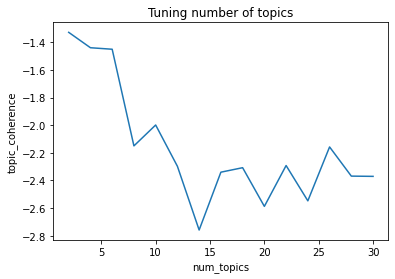

In [42]:
plt.plot(
    [candidate['num_topics'] for candidate in candidate_lda_models],
    [candidate['topic_coherence'] for candidate in candidate_lda_models]
)
plt.xlabel("num_topics")
plt.ylabel("topic_coherence")
plt.title("Tuning number of topics")
plt.show()

## Find the best model
Choosing a ‘k’ that marks the end of a rapid growth of topic coherence (for `c_v` cherence measure) usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

For `u_mass` coherence measure, we should choose the lowest negative value.

In [43]:
# Choose based on the plot
best_model_idx = 6

In [44]:
num_topics = candidate_lda_models[best_model_idx]['num_topics']

lda_model = candidate_lda_models[best_model_idx]['lda_model']
lda_model.save('lda.model')

# List the keywords for each topic and the weightage (importance) of each keyword

The weights reflect how important a keyword is to that topic.

In [45]:
# lda_model.show_topics(num_topics=num_topics, formatted=False)
lda_model.print_topics()

[(0,
  '0.021*"key" + 0.012*"space" + 0.011*"system" + 0.008*"information" + 0.007*"technology" + 0.007*"encryption" + 0.006*"chip" + 0.005*"message" + 0.005*"communication" + 0.005*"security"'),
 (1,
  '0.011*"israel" + 0.010*"jews" + 0.008*"war" + 0.008*"world" + 0.007*"turkish" + 0.006*"armenian" + 0.006*"people" + 0.006*"history" + 0.006*"israeli" + 0.005*"attack"'),
 (2,
  '0.010*"study" + 0.008*"science" + 0.006*"drug" + 0.006*"problem" + 0.005*"year" + 0.005*"test" + 0.005*"case" + 0.005*"effect" + 0.005*"time" + 0.005*"result"'),
 (3,
  '0.022*"people" + 0.016*"time" + 0.012*"happen" + 0.012*"start" + 0.012*"day" + 0.011*"leave" + 0.009*"live" + 0.008*"hear" + 0.008*"man" + 0.007*"woman"'),
 (4,
  '0.019*"file" + 0.015*"program" + 0.014*"window" + 0.010*"version" + 0.009*"image" + 0.007*"software" + 0.007*"server" + 0.007*"include" + 0.007*"run" + 0.007*"user"'),
 (5,
  '0.013*"line" + 0.011*"power" + 0.009*"work" + 0.006*"high" + 0.006*"low" + 0.006*"ground" + 0.006*"design" +

## Get a topic keywords and their weightage

In [46]:
def get_topic_keywords(lda_model: LdaMallet,
                       topic_id: int) -> List[Tuple[str, float]]:
  return lda_model.show_topic(topic_id)

In [47]:
get_topic_keywords(
    lda_model=lda_model,
    topic_id=0
)

[('key', 0.021244613688746368),
 ('space', 0.011991849550723185),
 ('system', 0.010789324247586598),
 ('information', 0.007799712730066473),
 ('technology', 0.007348765741390253),
 ('encryption', 0.006580485686608545),
 ('chip', 0.0056785917092561046),
 ('message', 0.005428065604435982),
 ('communication', 0.005327855162507934),
 ('security', 0.005327855162507934)]

In [48]:
from wordcloud import WordCloud

In [49]:
def plot_topic_word_cloud(lda_model: LdaMallet,
                          topic_id: int) -> None:
  keyword_frequencies = dict(
      get_topic_keywords(
          lda_model=lda_model,
          topic_id=topic_id
      )
  )

  wordcloud = WordCloud(background_color='white',
                        width=2500,
                        height=1800,
                        max_words=10,
                        colormap='tab10',
                        color_func=lambda *args, **kwargs: '#1f77b4',
                        prefer_horizontal=1.0)
  
  wordcloud.generate_from_frequencies(keyword_frequencies,
                                      max_font_size=300)
  
  plt.gca().imshow(wordcloud)
  plt.gca().set_title(
      'Top Keywords for topic #%d' % topic_id,
      fontdict=dict(size=16)
  )
  plt.gca().axis('off')

  plt.show()  

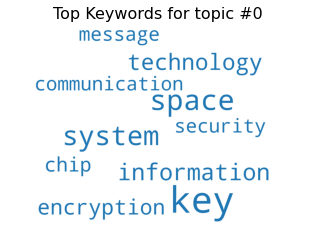

In [50]:
plot_topic_word_cloud(
    lda_model=lda_model,
    topic_id=0
)

## Visualize topic-term relevance and relationship
`pyLDAvis` (sievert-illvi2014 - https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) is designed to help users interpret the topics in an LDA topic model fitted to a corpus of text data.

you need to provide the topic-term distributions, document-topic distributions, and basic information about the corpus which the model was trained on to the function `prepare` that will transform your data into the format needed for the visualization.

Convert `MALLET`'s model to `Gensim`'s model in order to be used in `pyLDAvis` package.

In [51]:
lda_model_gensim = convert_mallet_model_to_gensim_model(lda_model)

In [52]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X

In [53]:
pyldavis_prepared_data = gensimvis.prepare(
    topic_model=lda_model_gensim,
    corpus=test_corpus_bow,
    dictionary=dictionary,
    # mds='tsne' # require that you have sklearn installed
)
 
pyLDAvis.save_html(pyldavis_prepared_data, 'pyLDAvis.html')
 
pyLDAvis.display(pyldavis_prepared_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


# Get Topic proportions and dominant topic

In [54]:
def get_topic_proportions(
    lda_model: LdaMallet,
    docs_bow: List[List[Tuple[int, int]]]
) -> List[List[Tuple[int, float]]]:
  return lda_model[docs_bow]


def sort_topic_proportions(
    unsorted_topic_proportions: List[Tuple[int, float]],
    reverse=True
) -> List[Tuple[int, float]]:
  return list(
      sorted(
          unsorted_topic_proportions,
          key=lambda t: t[1],
          reverse=reverse
      )
  )

In [55]:
%%time

train_corpus_topic_proportions = get_topic_proportions(lda_model,
                                                       train_corpus_bow)

test_corpus_topic_proportions = get_topic_proportions(lda_model,
                                                      test_corpus_bow)

print("Review:")
pprint(test_corpus_raw[0])
print("\n In order topics:")
pprint(test_corpus_topic_proportions[0])
print("\n Sorted topics:")
pprint(
    sort_topic_proportions(test_corpus_topic_proportions[0])
)

Review:
("from: x90sanson@gw.wmich.edu subject: what's the diff.between "
 "mouse.sys/com?? organization: western michigan university lines: 8 what's "
 'the difference between loading mouse.com in autoexec.bat and doing '
 'device=mouse.sys in config.sys?? which one is better? thanks a lot enrique')

 In order topics:
[(0, 0.06219099661722614),
 (1, 0.0749414519906323),
 (2, 0.06219099661722614),
 (3, 0.06219099661722614),
 (4, 0.06219099661722614),
 (5, 0.0858704137392662),
 (6, 0.058548009367681515),
 (7, 0.06947697111631537),
 (8, 0.06401249024199845),
 (9, 0.06219099661722614),
 (10, 0.06036950299245382),
 (11, 0.11137132448607857),
 (12, 0.06947697111631537),
 (13, 0.09497788186312776)]

 Sorted topics:
[(11, 0.11137132448607857),
 (13, 0.09497788186312776),
 (5, 0.0858704137392662),
 (1, 0.0749414519906323),
 (7, 0.06947697111631537),
 (12, 0.06947697111631537),
 (8, 0.06401249024199845),
 (0, 0.06219099661722614),
 (2, 0.06219099661722614),
 (3, 0.06219099661722614),
 (4, 0.062

## Plot topic proportions

REVIEW #0:
("from: x90sanson@gw.wmich.edu subject: what's the diff.between "
 "mouse.sys/com?? organization: western michigan university lines: 8 what's "
 'the difference between loading mouse.com in autoexec.bat and doing '
 'device=mouse.sys in config.sys?? which one is better? thanks a lot enrique')



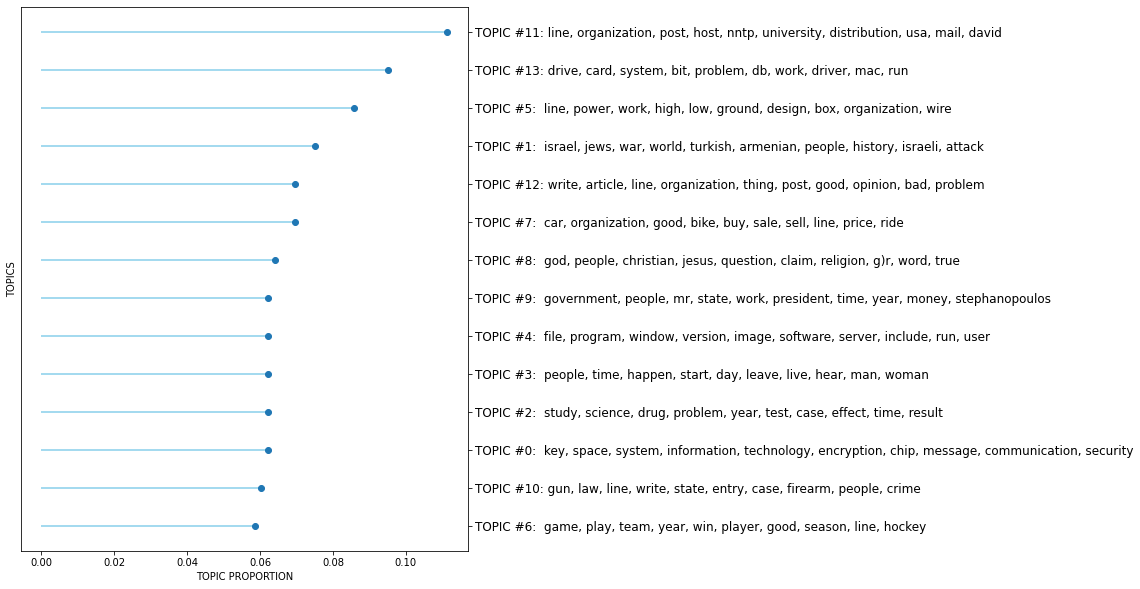

In [56]:
i = 0


print("REVIEW #%d:" % i)
pprint(test_corpus_raw[i])
print()


def print_keywords_text(lda_model: LdaMallet, topic_id: int) -> str:
  keywords = get_topic_keywords(lda_model, topic_id)
  keywords_text = [text for text, proportion in keywords]
  return ("TOPIC #%d: " % topic_id).ljust(11) + ", ".join(keywords_text)

# topic_proportions = test_corpus_topic_proportions[i]
topic_proportions = sort_topic_proportions(
    test_corpus_topic_proportions[i],
    reverse=False
)
proportions = [proportion for _, proportion in topic_proportions]
keywords = [print_keywords_text(lda_model, id) for id, _ in topic_proportions]

my_range = range(num_topics)


plt.figure(figsize=(8,10))
plt.hlines(
    y=my_range,
    xmin=0,
    xmax=proportions,
    color='skyblue'
)

# Plot
plt.plot(
    proportions,
    my_range,
    'o'
)
 
plt.gca().yaxis.set_ticks_position("right")
plt.yticks(
    my_range,
    keywords,
    fontsize=12
)
 
plt.ylabel('TOPICS')
plt.xlabel('TOPIC PROPORTION')

plt.show()

# Check out the dominant topic keywords for some randomly-selected unseen documents

In [57]:
num_docs = 10

for i in np.random.randint(len(testset_dataframe), size=num_docs):
  print("Review #%d:" % i)
  pprint(test_corpus_raw[i])

  sorted_topic_proportions = sort_topic_proportions(
      test_corpus_topic_proportions[i]
  )

  print("\nDominant Topic (%f) Keywords:" % sorted_topic_proportions[0][1])
  first_dominant_topic_id = sorted_topic_proportions[0][0]
  print(
      get_topic_keywords(
          lda_model,
          first_dominant_topic_id
      )
  )

  print("\nSecond Topic (%f) Keywords:" % sorted_topic_proportions[1][1])
  second_topic_id = sorted_topic_proportions[1][0]
  print(
      get_topic_keywords(
          lda_model,
          second_topic_id
      )
  )
 
  print("-" * 335)

Review #2029:
('organization: esoc european space operations centre from: '
 '<tnedderh@esoc.bitnet> subject: re: apollo training in iceland distribution: '
 'sci lines: 10 the apollo astronauts also trained at (in) meteor crater in '
 'the flagstaff area (arizona). there is now a museum with a space shop. '
 'caution: they ease you by 6$. compared to a ksc visit it is not worth. '
 '-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- '
 'thorsten nedderhut | disclaimer: mbp software & systems gmbh | c/o '
 'esa/esoc/fcsd/oad/stb | neither esa nor mbp is responsible darmstadt, '
 'germany | for my postings! tnedderh@esoc.bitnet |')

Dominant Topic (0.179954) Keywords:
[('key', 0.021244613688746368), ('space', 0.011991849550723185), ('system', 0.010789324247586598), ('information', 0.007799712730066473), ('technology', 0.007348765741390253), ('encryption', 0.006580485686608545), ('chip', 0.0056785917092561046), ('message', 0.005428065604435982), ('communication', 0.0

# Find the most representative documents in trainset for each topic
Find the documents in trainset a given topic has contributed to the most, in order to infer what a topic is actually about.

In [58]:
def get_most_representative_docs(docs_text: List[str],
                                 docs_topics: List[List[Tuple[int, float]]],
                                 topic: int,
                                 limit: int = 5) -> pd.DataFrame:
  docs_dominant_topic = [
                         sort_topic_proportions(doc_topics)[0]
                         for doc_topics in docs_topics
                        ]

  docs_topic_id, docs_topic_proportion = \
    tuple(map(list, zip(*docs_dominant_topic)))

  df = pd.DataFrame(
      {
          'raw_text': docs_text,
          'topic_id': docs_topic_id,
          'topic_proportion': docs_topic_proportion
      }
  ).groupby('topic_id').get_group(topic).sort_values(by='topic_proportion',
                                                     ascending = False,
                                                     ignore_index = True)
  
  return df.head(limit)

In [59]:
get_most_representative_docs(
    test_corpus_raw,
    test_corpus_topic_proportions,
    0,
    5
)

,raw_text,topic_id,topic_proportion
0,from: caronni@nessie.cs.id.ethz.ch (germano ca...,0,0.623952
1,from: crypt-comments@math.ncsu.edu subject: cr...,0,0.585235
2,from: karn@servo.qualcomm.com (phil karn) subj...,0,0.580472
3,from: koontzd@phobos.lrmsc.loral.com (david ko...,0,0.557660
4,from: pat@rwing.uucp (pat myrto) subject: new ...,0,0.547868


# Topic distribution across documents
The distribution of topics across all documents in a corpus demonstrates how widely the topics are discussed.

In [60]:
def get_topics_contribution_in_corpus(
    docs_topics: List[List[Tuple[int, float]]]
) -> pd.DataFrame:
  docs_dominant_topic = [
                         sort_topic_proportions(doc_topics)[0][0]
                         for doc_topics in docs_topics
                        ]

  return pd.Series(
      docs_dominant_topic
  ).value_counts(normalize=True).sort_index()

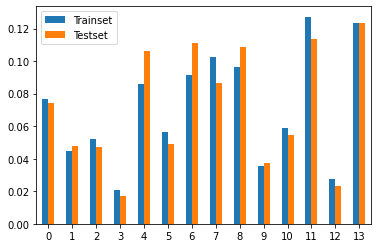

In [61]:
ax = pd.DataFrame(
    {
        'Trainset': get_topics_contribution_in_corpus(
            train_corpus_topic_proportions
        ),
        'Testset': get_topics_contribution_in_corpus(
            test_corpus_topic_proportions
        )
    }
).plot.bar(rot=0)